# 3rd Year Project - Alfred Backhouse
## Training creative cellular automata using GANs. 

# Set some initial parameters 

In [483]:
# Do we need to train the discriminator and generator?
# or just load the weights?
TRAIN_DISCRIMINATOR = False
TRAIN_GENERATOR = False
WGAN = False
TARGET_DIGIT = 8
iters_lower, iters_upper = 120, 121
CHANNEL_N = 16 # Number of CA state channels
CELL_FIRE_RATE = 0.5
noise_factor = 0
lr_gen = 2e-5
lr_disc = 1e-5
SEED_STD = 2

# Imports and image / video utities 

In [484]:
import os
import PIL.Image, PIL.ImageDraw
import numpy as np
import matplotlib.pylab as pl
import glob
import imageio
import time
import random

import tensorflow as tf
import tensorflow_docs.vis.embed as embed
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import backend
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import Constraint

from IPython.display import clear_output

clear_output()

# Load training data and show some examples

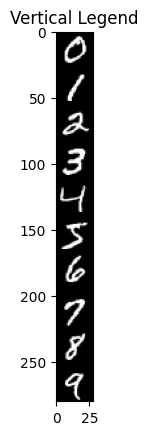

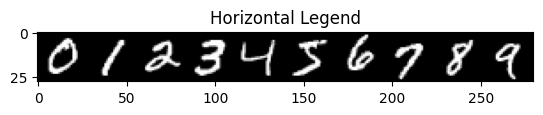

In [485]:
# @title Generate train/test set from MNIST.

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = 1 * ((train_images) / 255)
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Separate images of '1' and other digits
images_of_target = train_images[train_labels == TARGET_DIGIT]
images_of_others = train_images[train_labels != TARGET_DIGIT]

# Downsample the 'other digits' dataset to match the size of '1s' dataset
size_of_targets = images_of_target.shape[0]
downsampled_images_of_others = images_of_others[:size_of_targets]

# Combine and shuffle the datasets
combined_images = np.concatenate((images_of_target, downsampled_images_of_others), axis=0)
combined_labels = np.concatenate((np.ones(size_of_targets), np.zeros(size_of_targets)), axis=0)

# Create the TensorFlow dataset
x_train = tf.data.Dataset.from_tensor_slices((combined_images, combined_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# take a target image
target_image = images_of_target[5]

def to_ten_dim_label(x, y):
    # x shape is [b, r, c]
    # y shape is [b]
    y_res = np.zeros(list(x.shape) + [10])
    y_expanded = np.broadcast_to(y, x.T.shape).T
    y_res[x >= 0.1, y_expanded[x >= 0.1]] = 1.0
    return y_res.astype(np.float32)

y_train_pic = to_ten_dim_label(train_images, train_labels)

def find_bw_legend(x_set, y_set, orientation="vertical"):
    result_x = []
    for i in range(10):
        for x, y in zip(x_set, y_set):
            if y == i:
                result_x.append(x)
                break
    assert len(result_x) == 10

    if orientation == "vertical":
        result_x = np.concatenate(result_x, axis=0)
    else:
        result_x = np.concatenate(result_x, axis=1)

    return result_x

# Create vertical and horizontal black and white legends
bw_legend_vertical = find_bw_legend(train_images, train_labels, orientation="vertical")
bw_legend_horizontal = find_bw_legend(train_images, train_labels, orientation="horizontal")

# Show the legend using matplotlib or some other library of your choice
import matplotlib.pyplot as plt

plt.imshow(bw_legend_vertical, cmap='gray')
plt.title('Vertical Legend')
plt.show()

plt.imshow(bw_legend_horizontal, cmap='gray')
plt.title('Horizontal Legend')
plt.show()


# Build the CA / generator model (with some utitilies for this)

In [486]:
#@title CA model and utils
def to_greyscale(x):
    return tf.clip_by_value(x[..., 0:1], 0.0, 1.0)

def get_living_mask(x):
    alpha = x[:, :, :, 0:1]
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def make_seed(num_examples):
    h, w = 28,28
    seed = np.zeros([num_examples, h, w, CHANNEL_N], np.float32)
    for i in range(h//2 - 1, h//2 + 1):
        for j in range(w//2-1, w//2 + 1):
            seed[:, i, j, 0] = np.random.uniform(1, 1, size = num_examples)
            seed[:, i, j, 1:] = np.random.normal(0, SEED_STD, size = seed[:, i, j, 1:].shape)
    return seed

class CustomInitializer(Initializer):
    def __init__(self, mean=0.0, stddev=0.01):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, shape, dtype=np.float32):
        return tf.random.normal(shape, mean=self.mean, stddev=self.stddev, dtype=dtype)

class build_generator(tf.keras.Model):

    def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE, l2_reg = 0):
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate
        self.custom_init = CustomInitializer(mean=0) #was 0.008

        self.perceive = tf.keras.Sequential([
            Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
        ])

        self.dmodel = tf.keras.Sequential([
            Conv2D(80, 1, activation=tf.nn.relu, kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
            Conv2D(self.channel_n, 1, activation=None,
                kernel_initializer=self.custom_init, kernel_regularizer=l2(l2_reg)),
        ])

        self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

    def reinitialize_weights(self):
        for layer in self.dmodel.layers:
            if hasattr(layer, 'kernel_initializer'):
                layer.kernel.assign(self.custom_init(layer.kernel.shape))
            if hasattr(layer, 'bias_initializer') and layer.use_bias:
                layer.bias.assign(self.custom_init(layer.bias.shape))

    @tf.function
    def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
        pre_life_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y)*step_size
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :])) <= fire_rate
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask

        return x * tf.cast(life_mask, tf.float32)

build_generator().dmodel.summary()

Model: "sequential_207"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_326 (Conv2D)         (1, 3, 3, 80)             6480      
                                                                 
 conv2d_327 (Conv2D)         (1, 3, 3, 16)             1296      
                                                                 
Total params: 7776 (30.38 KB)
Trainable params: 7776 (30.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Build the discriminator (plus utitlies)

In [487]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

def build_discriminator(input_shape=(28, 28, 1)):

    const = ClipConstraint(0.01)
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_constraint=const,
                                     input_shape=[28, 28, 1]))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_constraint=const))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))

    return model

discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.summary()


Model: "sequential_208"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_328 (Conv2D)         (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_64 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_64 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_64 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_329 (Conv2D)         (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_65 (Ba  (None, 7, 7, 128)         512       
 tchNormalization)                                  

# Train utilities

In [488]:
def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()

def generate_and_save_images(model, epoch, test_input):

    x = test_input

    iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)

    for i in tf.range(iter_n):
        x = model(x, training=False)

    predictions = x

    if test_input.shape[0] == 1:
        plt.imshow(to_greyscale(predictions)[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()
    elif test_input.shape[0] == 16:
        print_image_sample(predictions)

    return to_greyscale(predictions)[0, :, :, 0]

def print_image_sample(images): 
    plt.figure(figsize=(10, 10))
    images = to_greyscale(images)
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

def noisify(images, noise_factor):

    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise
    # Clip the values to be between 0 and 1
    noisy_images = tf.clip_by_value(noisy_images, clip_value_min=0.0, clip_value_max=1.0)
    return noisy_images

def add_noise_to_weights(model, noise_level=0.01):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Check if the layer has weights
            noisy_weights = [w + noise_level * np.random.randn(*w.shape) for w in weights]
            layer.set_weights(noisy_weights)

# Function to plot the current losses
def plot_losses(generator_losses, discriminator_losses, epoch):
    fig, axs = plt.subplots(2, figsize=(10, 10))

    axs[0].plot(generator_losses, label='Generator')
    axs[0].set_title(f'Generator Loss During Training - Epoch {epoch}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(discriminator_losses, label='Discriminator')
    axs[1].set_title(f'Discriminator Loss During Training - Epoch {epoch}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Show target image
We are aiming to create an exact replica during the pretraining of the generator 

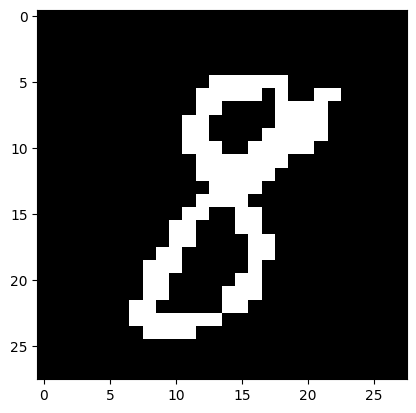

In [489]:
rounded_target_image = tf.where(target_image > 0.5, 1.0, 0.0)
plt.imshow(rounded_target_image[:, :, :] * 127.5 + 127.5, cmap='gray')

# Pretrain the generator 
We are using the original training architecture

In [490]:
h = 28
w = 28
seed = make_seed(1)

def loss_f(x):
  return tf.reduce_mean(tf.square(to_greyscale(x)-rounded_target_image), [-2, -3, -1])

ca = build_generator()
loss_log = []
lr = 2e-4
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.legacy.Adam(lr_sched)
loss0 = loss_f(seed).numpy()

@tf.function
def train_step(x):
  iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x))
    reg_losses = tf.add_n(ca.dmodel.losses)
    total_loss = loss + reg_losses
  grads = g.gradient(total_loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, total_loss

if TRAIN_GENERATOR: 
  for i in range(3000+1):
      x0 = make_seed(256) 
      x, loss = train_step(x0)
      step_i = len(loss_log)
      loss_log.append(loss.numpy())
      if step_i%100 == 0:
          clear_output(wait=True)
          if tf.reduce_all(generate_and_save_images(ca,
                                  i + 1,
                                  x0) == 0.0): 
              ca.reinitialize_weights() # restart training if the model collapses
          # Print the losses
          print(f"Epoch {i + 1}, Loss: {loss:.4f}")
          plot_loss(loss_log)
      print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

Save the weights if we have just trained them

In [491]:
if TRAIN_GENERATOR: 
  ca.save_weights(f"ca_{TARGET_DIGIT}.h5")

Else load the pretrained weights

In [492]:
ca.load_weights(f"ca_{TARGET_DIGIT}.h5")
generator = build_generator()
generator.load_weights(f"ca_{TARGET_DIGIT}.h5")

# Setup loss functions 

In [493]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def wasserstein_loss(y_true, y_pred):
    y_true = tf.where(y_true == 1., tf.constant(-1., dtype=tf.float32), tf.constant(1., dtype=tf.float32))
    return tf.keras.backend.mean(y_true * y_pred)

def generator_loss(fake_output):
    # return -tf.reduce_mean(fake_output) # WGAN
    if WGAN: 
        wgan_loss = wasserstein_loss(tf.ones_like(fake_output), fake_output)
        l2_loss = tf.add_n(ca.dmodel.losses)
        return wgan_loss + l2_loss
    else: 
        cross_entropy_loss = cross_entropy(tf.ones_like(fake_output), fake_output) # Normal cross entropy
        l2_loss = tf.add_n(ca.dmodel.losses)
        return cross_entropy_loss + l2_loss

def pretrain_disc_loss(real_output, real_labels, fake_output):
    real_targets = tf.where(real_labels == 1., tf.ones_like(real_labels), tf.zeros_like(real_labels))
    real_loss = cross_entropy(real_targets, real_output)
    return real_loss

def discriminator_loss(real_output, real_labels, fake_output):

    if WGAN:
        real_targets = tf.where(real_labels == 1., tf.ones_like(real_labels), tf.zeros_like(real_labels))
        
        real_loss = wasserstein_loss(real_targets, real_output)
        # return real_loss
        fake_loss = wasserstein_loss(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss
    else: 
        real_targets = tf.where(real_labels == 1., tf.ones_like(real_labels), tf.zeros_like(real_labels))
        
        real_loss = cross_entropy(real_targets, real_output)
        # return real_loss
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss

# Main GAN train loop (used for disc pretrain also )

In [494]:
@tf.function
def disc_pre_train_step(images, labels, update_gen=False, update_disc=True, gen_batch_size = 1):
    iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)

    x = make_seed(gen_batch_size)  

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        for i in tf.range(iter_n):
            x = generator(x, training=True)  # Process the entire batch
        real_output = discriminator(noisify(images, noise_factor), training=True)
        fake_output = discriminator(noisify(to_greyscale(x)[:, :, :, 0], noise_factor), training=True)
        disc_loss = pretrain_disc_loss(real_output, labels,  fake_output)
        gen_loss = generator_loss(fake_output)

    # Compute gradients and update weights
    if update_gen:
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_generator = [g/(tf.norm(g)+1e-8) for g in gradients_of_generator]
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # if disc_loss > gen_loss / 4 or disc_loss > gen_loss:
    if update_disc:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

@tf.function
def train_step(images, labels, update_gen=True, update_disc=True, gen_batch_size = 1):
    iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)

    x = make_seed(gen_batch_size)  

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        for i in tf.range(iter_n):
            x = generator(x, training=True)  # Process the entire batch
        real_output = discriminator(noisify(images, noise_factor), training=True)
        fake_output = discriminator(noisify(to_greyscale(x)[:, :, :, 0], noise_factor), training=True)
        disc_loss = discriminator_loss(real_output, labels,  fake_output)
        gen_loss = generator_loss(fake_output)

    # Compute gradients and update weights
    if update_gen:
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_generator = [g/(tf.norm(g)+1e-8) for g in gradients_of_generator]
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # if disc_loss > gen_loss / 4 or disc_loss > gen_loss:
    if update_disc:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training Loop
def train(dataset, epochs, gen_iters_per_disc_iter=1, add_noise_every=1, gen_batch_size=1, pretraining_disc = False):

    # Initialise lists for storing losses
    generator_losses = []
    discriminator_losses = []
    update_disc = tf.constant(False)
    clear_output(wait=True)
    generate_and_save_images(generator,
                            0,
                            make_seed(gen_batch_size))

    print("Getting warmed up...")

    for epoch in range(epochs):
        start = time.time()

        # Initialise the loss accumulators for the epoch
        epoch_gen_loss = 0.0
        epoch_disc_loss = 0.0
        batch_count = 0

        # Determine the number of batches to sample (1/10th of the dataset)
        total_batches = len(dataset)
        sampled_batches = total_batches // 5

        # Sample a subset of batches to iterate over
        sampled_dataset = dataset.shuffle(BUFFER_SIZE).take(sampled_batches)
        
        for image_batch, label_batch in sampled_dataset:
            # print_image_sample(image_batch[:16])
            # print(label_batch)

            if (epoch) % add_noise_every == 0: 
                add_noise_to_weights(generator, noise_level=0)
            
            if (epoch) % gen_iters_per_disc_iter == 0: 
                update_disc = tf.constant(True)
            else: 
                update_disc = tf.constant(False)
            
            if pretraining_disc: 
                gen_loss, disc_loss = disc_pre_train_step(image_batch, label_batch)
            else: 
                gen_loss, disc_loss = train_step(image_batch, label_batch, update_disc=update_disc, gen_batch_size=gen_batch_size)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            batch_count += 1


        # Average the losses over all batches in the epoch
        epoch_gen_loss /= batch_count
        epoch_disc_loss /= batch_count

        epoch_gen_loss = epoch_gen_loss
        epoch_disc_loss = epoch_disc_loss

        # Append the average losses to their respective lists
        generator_losses.append(epoch_gen_loss)
        discriminator_losses.append(epoch_disc_loss)

        # Produce images for the GIF as you go
        clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                make_seed(gen_batch_size))
        print(batch_count)
        # Print the losses
        print(f"Epoch {epoch + 1}, Generator loss: {epoch_gen_loss:.4f}, Discriminator loss: {epoch_disc_loss:.4f}")
        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec")
        plot_losses(generator_losses, discriminator_losses, epoch + 1)


        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    # Generate after the final epoch
    clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            make_seed(gen_batch_size))
    plot_losses(generator_losses, discriminator_losses, epoch + 1)

# Setup learning rates, optimizers etc. 

In [495]:
EPOCHS = 1000
seed = make_seed(1)

g_loss_log = []
d_loss_log = []

loss0 = generator_loss(seed).numpy()

lr_sched_gen = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr_gen, lr_gen * 0.1])
lr_sched_disc = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr_disc, lr_disc * 0.1])

# Optimizers
generator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_gen)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_disc)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Pretrain the discriminator

In [496]:
if TRAIN_DISCRIMINATOR:

    g_loss_log = []
    d_loss_log = []

    loss0 = generator_loss(seed).numpy()

    lr_sched_gen = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [2000], [lr_gen, lr_gen * 0.1])
    lr_sched_disc = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [2000], [lr_disc, lr_disc * 0.1])

    # Optimizers
    generator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_gen)
    discriminator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_disc)

    train(x_train, EPOCHS, pretraining_disc=True)

Save the weights if we have just trained them

In [497]:
if TRAIN_DISCRIMINATOR:
  discriminator.save_weights(f"disc_{TARGET_DIGIT}.h5")

  # Restore the loss logs and lr schedulers

  g_loss_log = []
  d_loss_log = []

  loss0 = generator_loss(seed).numpy()
  lr_sched_gen = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [2000], [lr_gen, lr_gen * 0.1])
  lr_sched_disc = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [2000], [lr_disc, lr_disc * 0.1])

  # Optimizers
  generator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_gen)
  discriminator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_disc)

Else load new ones

In [498]:
discriminator.load_weights(f"disc_{TARGET_DIGIT}.h5")

# TRAIN!!!

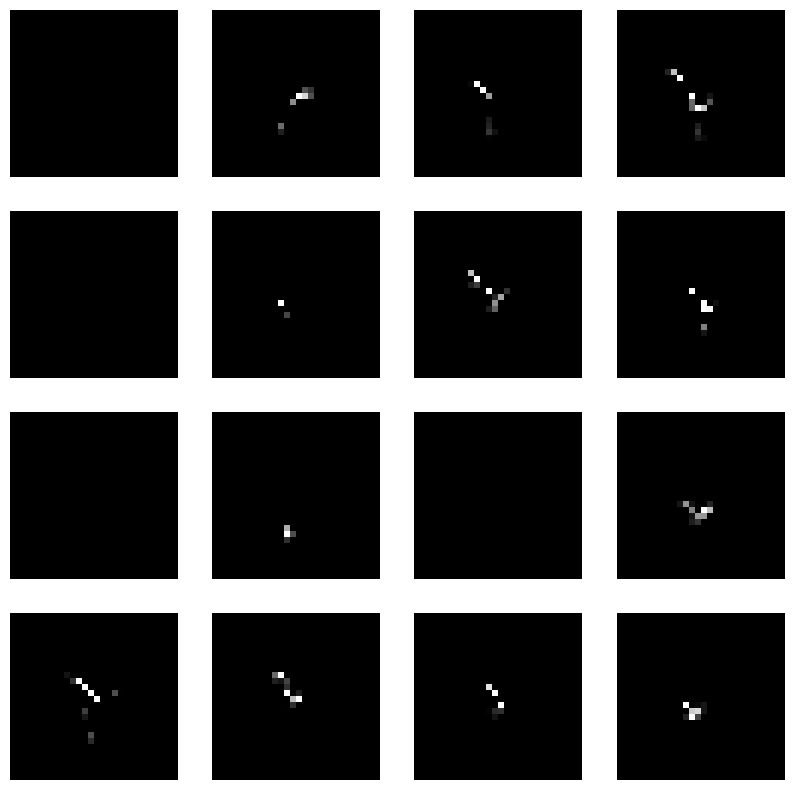

9
Epoch 76, Generator loss: 4.2876, Discriminator loss: 0.1696
Time for epoch 76 is 11.892484903335571 sec


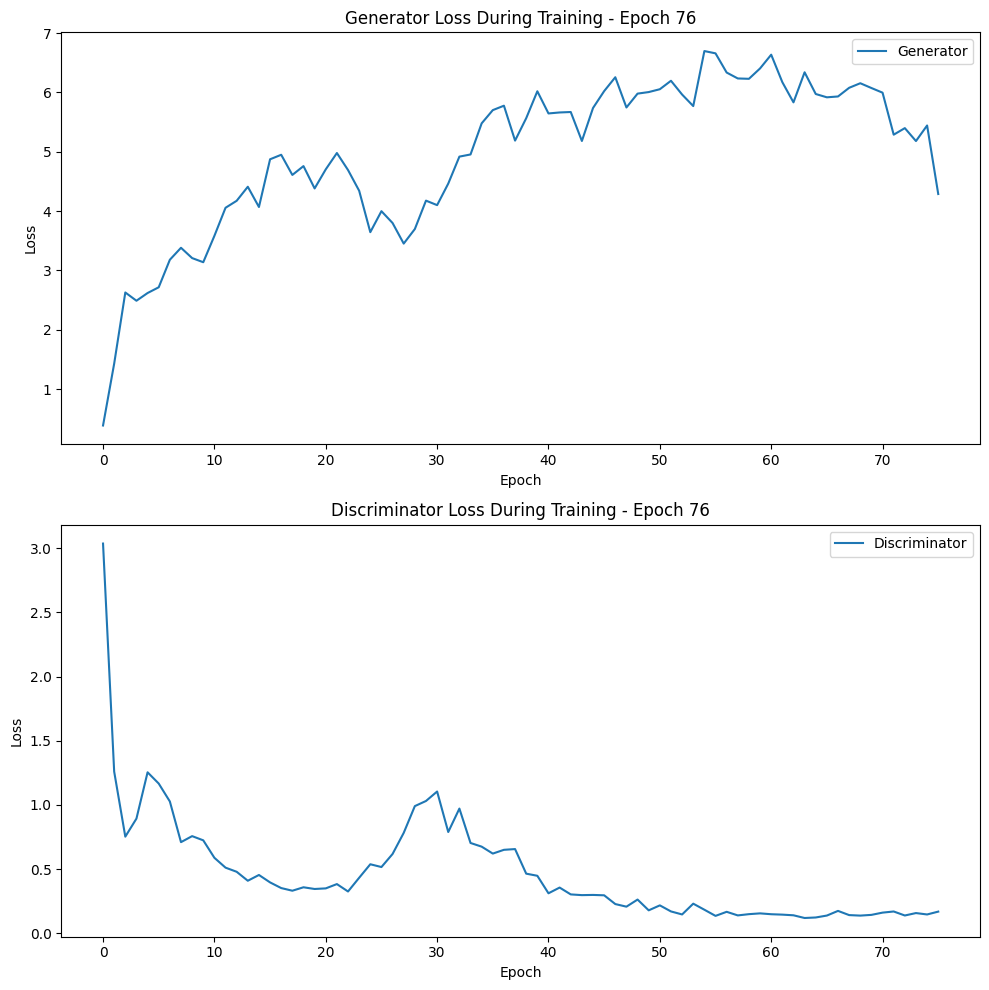

KeyboardInterrupt: 

In [499]:
train(x_train, EPOCHS, gen_iters_per_disc_iter=1, add_noise_every=1, gen_batch_size=16)

# Some evaluation
Display images of 8s, others, and the generated image together with their discriminator scores

8s

In [ ]:
print_image_sample(noisify(images_of_target[:16], 0))
print(tf.sigmoid(discriminator(images_of_target[:16])))

Others

In [ ]:
print_image_sample(noisify(images_of_others[:16], 0))
print(tf.sigmoid(discriminator(images_of_others[:16])))

Generated image

In [ ]:
seeds = make_seed(16)
image = noisify(generate_and_save_images(generator,16,seed)[None,...], 0)
print(tf.sigmoid(discriminator(image)))

# Save a gif of the training loop 

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

embed.embed_file(anim_file)